In [1]:
!pip install ydata-profiling
!pip install faker
!pip install lazypredict
!pip install xgboost
!pip install lightgbm
!pip install scikit-learn
!pip install evidently
!pip install shap
!pip install lime


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=da7f4602439d56aedd7f42a70a4868bbbeb319cf972820558a48c9d5c3400e85
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import random

from faker import Faker
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

from evidently import Report
from evidently import Dataset, DataDefinition
from evidently.descriptors import Sentiment, TextLength, Contains
from evidently.presets import TextEvals
from evidently.presets import DataDriftPreset
from evidently.presets import ClassificationPreset

from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    DataCollatorWithPadding
)
import lime.lime_text

In [3]:

def generate_fake_data(num_records=50000):
  """
  Generates fake data
  """
  fake = Faker()
  data = []
  for _ in range(num_records):
      provider_id = fake.uuid4()
      cpt_code = f"{random.randint(10000, 99999)}"
      service_date = fake.date_between(start_date='-10y', end_date='today')
      amount = round(random.uniform(10.0, 1000.0), 2)
      whistleblower_notes = fake.text(max_nb_chars=400)
      whistleblower_fraud = random.random() < 0.3  # Adjust for how often a whistleblower reports fraud
      # Assign fraud label (5-10% fraud)
      is_fraud = random.random() < 0.075  # Adjust this probability for desired fraud percentage
      fraud_label = "1" if is_fraud else "0" # 0 = not fraud, 1 = fraud

      data.append({
          "provider_id": provider_id,
          "cpt_code": cpt_code,
          "service_date": service_date,
          "amount": amount,
          "fraud_label": fraud_label,
          "whistleblower_notes": whistleblower_notes,
          "whistleblower_fraud": whistleblower_fraud
      })

  df = pd.DataFrame(data)

  df.to_csv("healthcare_data_with_fraud.csv", index=False)

  print("Healthcare data with fraud labels generated and saved to healthcare_data_with_fraud.csv")


generate_fake_data(num_records=50000)

Healthcare data with fraud labels generated and saved to healthcare_data_with_fraud.csv


In [10]:

def exploratory_data_analysis(csv_path="healthcare_data_with_fraud.csv"):
  # Load the dataset
  df = pd.read_csv(csv_path)

  # Generate the profile report
  profile = ProfileReport(df, title="Healthcare Data with Fraud Profile Report")

  # Save the report to an HTML file
  profile.to_file("healthcare_data_with_fraud_report.html")

  print("Profile report generated and saved as healthcare_data_with_fraud_report.html")

exploratory_data_analysis(csv_path="healthcare_data_with_fraud.csv")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report generated and saved as healthcare_data_with_fraud_report.html


In [17]:
# Load the dataset
df = pd.read_csv("healthcare_data_with_fraud.csv")

df = df.set_index("provider_id", drop=True)

# Convert columns to numerical or drop for simplicity in this example
df = df.drop(columns=['service_date', "whistleblower_notes", "whistleblower_fraud"], axis=1)


# Define features (X) and target (y)
X = df.drop('fraud_label', axis=1)
y = df['fraud_label']


# Split the data into training, validation, and test sets (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) # 30% for temp (validation + test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp) # Split temp 50/50 for validation/test

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

print(df.head())

Training set size: 35000
Validation set size: 7500
Test set size: 7500
                                      cpt_code  amount  fraud_label
provider_id                                                        
79efb080-41fa-4eb3-bdfc-7ad87084c100     49948   54.50            0
5fd64a9f-4ddb-4f86-955f-d347275299b5     89058  820.93            0
57e5c7ed-6c45-4fdd-b2ee-e2e97263a7db     88775  777.71            0
8a421f9c-c4bc-41e0-a3dc-202b64f44f89     30831  608.37            0
7b2bcde9-b5b3-441f-8be6-cad74468cbc2     30543  506.36            0


In [18]:

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and predict using the training and test sets
# Note: LazyClassifier typically uses training and test sets for comparison.
# We will use X_train and X_test here as is standard for LazyPredict.
# For a full workflow, you would train on X_train and evaluate on X_val for model selection,
# then do final evaluation on X_test.
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2555, number of negative: 32445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073000 -> initscore=-2.541494
[LightGBM] [Info] Start training from score -2.541494


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.93,0.50,0.50,0.89,12.74
ExtraTreesClassifier,0.92,0.50,0.50,0.89,2.44
BaggingClassifier,0.92,0.50,0.50,0.89,2.23
AdaBoostClassifier,0.93,0.50,0.50,0.89,1.15
DummyClassifier,0.93,0.50,0.50,0.89,0.02
BernoulliNB,0.93,0.50,0.50,0.89,0.03
GaussianNB,0.93,0.50,0.50,0.89,0.03
LinearDiscriminantAnalysis,0.93,0.50,0.50,0.89,0.04
LabelPropagation,0.93,0.50,0.50,0.89,29.21


In [20]:

# Initialize the classifiers
lr_model = LogisticRegression(random_state=42)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)

# Train the models on the first 100 sampples to keep training fast
print("Training Logistic Regression...")
lr_model.fit(X_train[:100], y_train[:100])
print("Training XGBoost...")
xgb_model.fit(X_train[:100], y_train[:100])
print("Training LightGBM...")
lgb_model.fit(X_train[:100], y_train[:100])

# Make predictions on the test set
print("Making predictions...")
lr_pred = lr_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)

# Make probability predictions for AUC
lr_proba = lr_model.predict_proba(X_test)[:, 1]
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]



Training Logistic Regression...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 8, number of negative: 92
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080000 -> initscore=-2.442347
[LightGBM] [Info] Start training from score -2.442347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [21]:
# Evaluate models using scikit-learn metrics
print("\nEvaluation using scikit-learn:")
print("Logistic Regression - Precision:", precision_score(y_test, lr_pred, pos_label=1))
print("Logistic Regression - Recall:", recall_score(y_test, lr_pred, pos_label=1))
print("Logistic Regression - AUC:", roc_auc_score(y_test, lr_proba))
print("-" * 30)
print("XGBoost - Precision:", precision_score(y_test, xgb_pred, pos_label=1))
print("XGBoost - Recall:", recall_score(y_test, xgb_pred, pos_label=1))
print("XGBoost - AUC:", roc_auc_score(y_test, xgb_proba))
print("-" * 30)
print("LightGBM - Precision:", precision_score(y_test, lgb_pred, pos_label=1))
print("LightGBM - Recall:", recall_score(y_test, lgb_pred, pos_label=1))
print("LightGBM - AUC:", roc_auc_score(y_test, lgb_proba))

# Make predictions on the validation set
print("Making predictions on validation set...")
lr_pred_val = lr_model.predict(X_val)
xgb_pred_val = xgb_model.predict(X_val)
lgb_pred_val = lgb_model.predict(X_val)

# Make probability predictions for AUC on validation set
lr_proba_val = lr_model.predict_proba(X_val)[:, 1]
xgb_proba_val = xgb_model.predict_proba(X_val)[:, 1]
lgb_proba_val = lgb_model.predict_proba(X_val)[:, 1]


# Evaluate models using scikit-learn metrics on Validation Set
print("\nEvaluation using scikit-learn on Validation Set:")
print("Logistic Regression - Precision:", precision_score(y_val, lr_pred_val, pos_label=1))
print("Logistic Regression - Recall:", recall_score(y_val, lr_pred_val, pos_label=1))
print("Logistic Regression - AUC:", roc_auc_score(y_val, lr_proba_val))
print("-" * 30)
print("XGBoost - Precision:", precision_score(y_val, xgb_pred_val, pos_label=1))
print("XGBoost - Recall:", recall_score(y_val, xgb_pred_val, pos_label=1))
print("XGBoost - AUC:", roc_auc_score(y_val, xgb_proba_val))
print("-" * 30)
print("LightGBM - Precision:", precision_score(y_val, lgb_pred_val, pos_label=1))
print("LightGBM - Recall:", recall_score(y_val, lgb_pred_val, pos_label=1))
print("LightGBM - AUC:", roc_auc_score(y_val, lgb_proba_val))
print("=" * 50)


# Evaluate models using scikit-learn metrics on Test Set
print("\nEvaluation using scikit-learn on Test Set:")
print("Logistic Regression - Precision:", precision_score(y_test, lr_pred, pos_label=1))
print("Logistic Regression - Recall:", recall_score(y_test, lr_pred, pos_label=1))
print("Logistic Regression - AUC:", roc_auc_score(y_test, lr_proba))
print("-" * 30)
print("XGBoost - Precision:", precision_score(y_test, xgb_pred, pos_label=1))
print("XGBoost - Recall:", recall_score(y_test, xgb_pred, pos_label=1))
print("XGBoost - AUC:", roc_auc_score(y_test, xgb_proba))
print("-" * 30)
print("LightGBM - Precision:", precision_score(y_test, lgb_pred, pos_label=1))
print("LightGBM - Recall:", recall_score(y_test, lgb_pred, pos_label=1))
print("LightGBM - AUC:", roc_auc_score(y_test, lgb_proba))
print("=" * 30)


Evaluation using scikit-learn:
Logistic Regression - Precision: 0.0
Logistic Regression - Recall: 0.0
Logistic Regression - AUC: 0.5110113846140093
------------------------------
XGBoost - Precision: 0.11570247933884298
XGBoost - Recall: 0.025594149908592323
XGBoost - AUC: 0.5075587169112223
------------------------------
LightGBM - Precision: 0.08333333333333333
LightGBM - Recall: 0.005484460694698354
LightGBM - AUC: 0.5024853475582068
Making predictions on validation set...

Evaluation using scikit-learn on Validation Set:
Logistic Regression - Precision: 0.0
Logistic Regression - Recall: 0.0
Logistic Regression - AUC: 0.5107378646485179
------------------------------
XGBoost - Precision: 0.03937007874015748
XGBoost - Recall: 0.009124087591240875
XGBoost - AUC: 0.5013642820844497
------------------------------
LightGBM - Precision: 0.02857142857142857
LightGBM - Recall: 0.0018248175182481751
LightGBM - AUC: 0.5132854432479652

Evaluation using scikit-learn on Test Set:
Logistic Regr


XGBoost Feature Importances (Gain):
cpt_code: 0.3021
amount: 0.2477


<Figure size 1000x800 with 0 Axes>

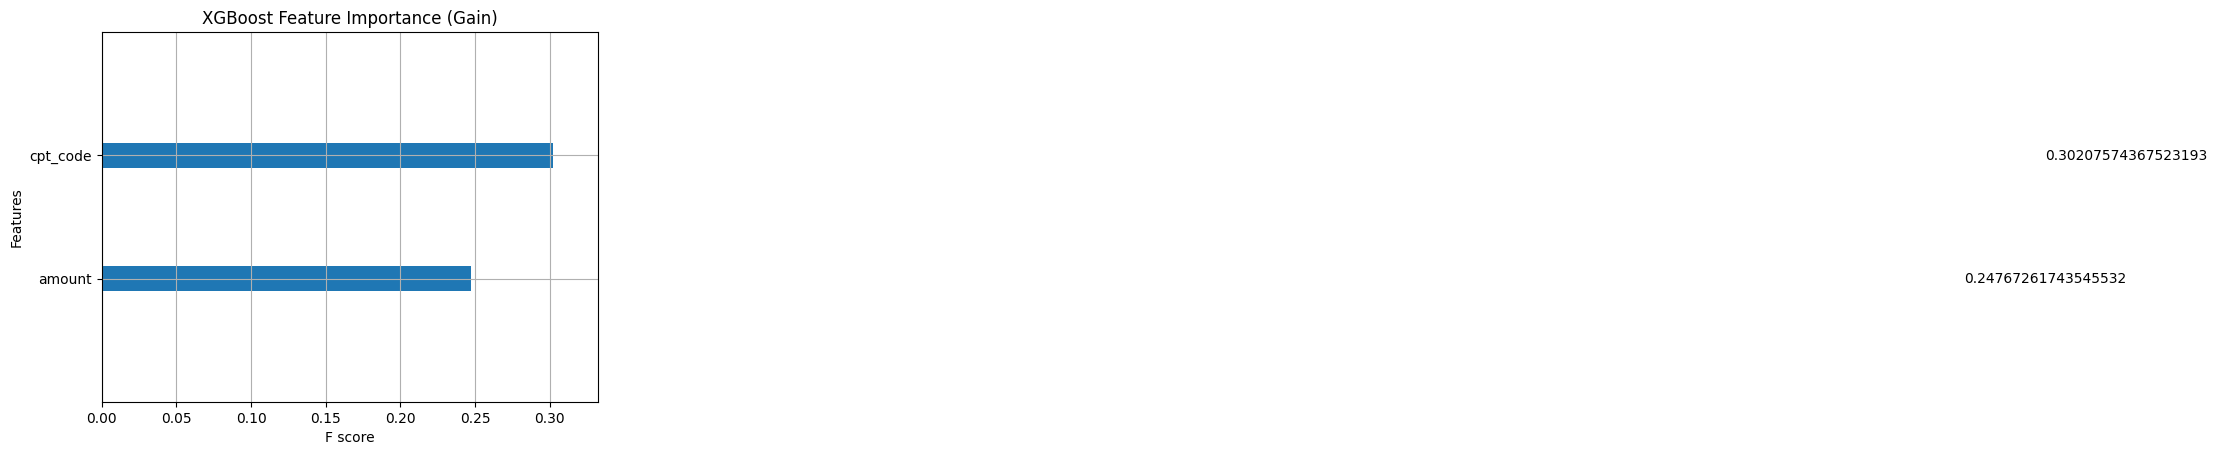

In [22]:
# Get feature importance from the trained XGBoost model
# 'gain' is a common type of importance that considers the average gain of splits where the feature is used.
feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

# Sort the features by importance in descending order
sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)

print("\nXGBoost Feature Importances (Gain):")
# Print the sorted list of feature importances
for feature, importance in sorted_importances:
  print(f"{feature}: {importance:.4f}")

# You can also visualize this
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

Confusion Matrices for Validation Set:


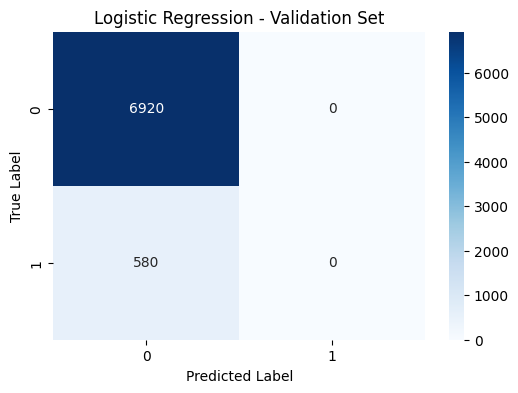

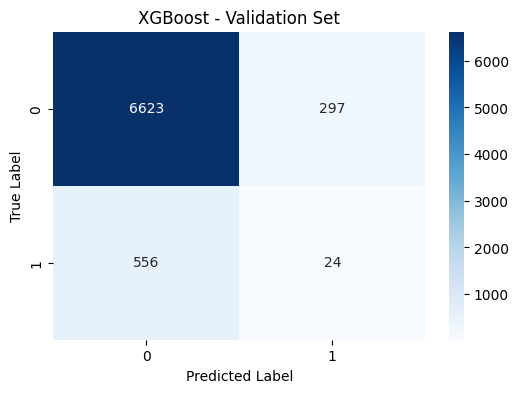

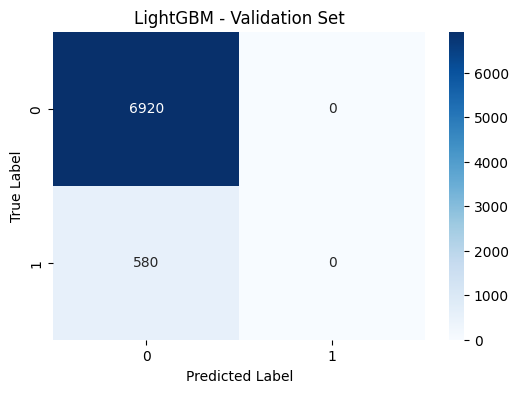


Confusion Matrices for Test Set:


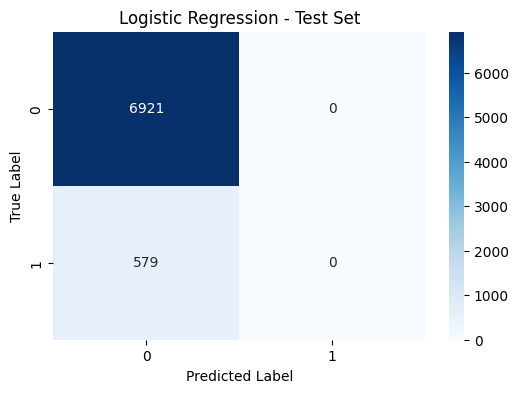

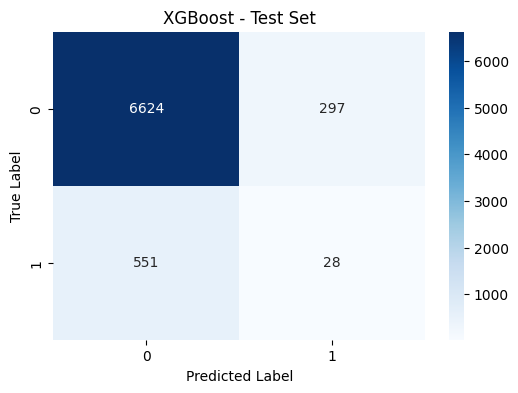

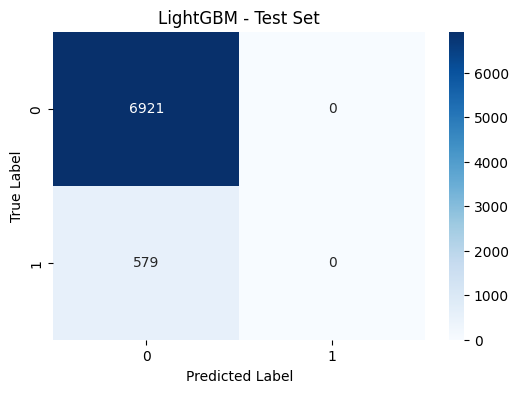

In [11]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Confusion matrices for Validation Set
print("Confusion Matrices for Validation Set:")
plot_confusion_matrix(y_val, lr_pred_val, 'Logistic Regression - Validation Set')
plot_confusion_matrix(y_val, xgb_pred_val, 'XGBoost - Validation Set')
plot_confusion_matrix(y_val, lgb_pred_val, 'LightGBM - Validation Set')

# Confusion matrices for Test Set
print("\nConfusion Matrices for Test Set:")
plot_confusion_matrix(y_test, lr_pred, 'Logistic Regression - Test Set')
plot_confusion_matrix(y_test, xgb_pred, 'XGBoost - Test Set')
plot_confusion_matrix(y_test, lgb_pred, 'LightGBM - Test Set')


In [65]:

# --- Data Drift Detection ---

# Create an Evidently Report for Data Drift
report = Report([
    DataDriftPreset()
])


# Corrected column names for features of interest
features_of_interest = ["amount"]

# Select the specified features from X_train and also include the target variable y_train
# We'll use the training data as our reference baseline
# Run the report
data_drift_report = report.run(reference_data=X_train[features_of_interest],
                      current_data=X_test[features_of_interest])

data_drift_report.save_html("data_drift_report.html")


#pretend we found it
drift_detected = True

# Example of a feedback trigger logic based on data drift:
if drift_detected:
  print("\n--- Data Drift Detected ---")
  print("Consider retraining the model with the new data.")
  # You could add more sophisticated logic here, like:
  # - Sending an alert to slack

  # - Triggering an automatic retraining pipeline
  # - Analyzing which features have drifted the most

# --- Model Performance Monitoring and Potential Feedback Trigger ---
# We can use Evidently's ClassificationPreset to monitor model performance over time
# For a real-world scenario, you would collect feedback (true labels) for the predictions
# made on current data. Here, we'll simulate having feedback by using the test set labels.

# For this example, we'll monitor the performance of the XGBoost model.
# In a real deployment, you would collect new data and its corresponding true labels.




--- SHAP Explainability ---
Generating SHAP Summary Plot...


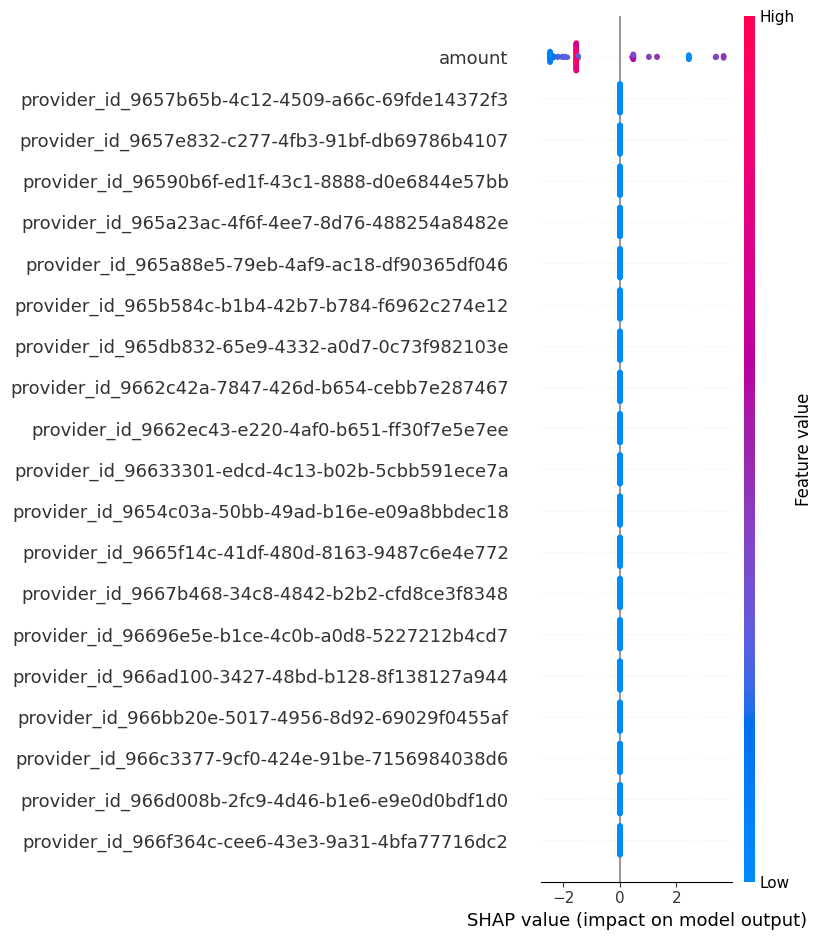


No 'Fraud' predictions found in the SHAP subset to explain with Force Plot.

Explaining a few random predictions using SHAP Force Plot:

Explanation for Instance (Original Index: 37696):

Explanation for Instance (Original Index: 20669):

Explanation for Instance (Original Index: 18998):

--- LIME Explainability ---


In [ ]:
# --- Explainability  using SHAP ---
print("\n--- SHAP Explainability ---")

# SHAP requires an explainer based on the model type
# For tree-based models like XGBoost, TreeExplainer is suitable
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for a subset of the test data for speed
# Explaining all test data can be computationally expensive
X_test_subset = X_test.sample(n=min(100, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_test_subset)

# SHAP Summary Plot: Visualizes the importance of each feature across the subset
# This plot shows the distribution of SHAP values for each feature.
# Features are ordered by their overall importance.
# The color indicates the feature value (e.g., red for high, blue for low).
# Each dot represents an instance from the dataset subset.
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_subset)
plt.show()

# SHAP Force Plot: Explain a single prediction
# Let's explain a few predictions, focusing on 'Fraud' cases if possible.
# Find indices of 'Fraud' predictions in the subset
fraud_indices_subset = X_test_subset.index[xgb_model.predict(X_test_subset) == 'Fraud'].tolist()

if fraud_indices_subset:
    print(f"\nExplaining {min(3, len(fraud_indices_subset))} high-risk (Fraud) predictions using SHAP Force Plot:")
    for i, original_index in enumerate(fraud_indices_subset[:3]): # Explain up to 3 fraud cases
        # Get the index within the subset
        index_in_subset = X_test_subset.index.get_loc(original_index)
        print(f"\nExplanation for Instance (Original Index: {original_index}):")
        # For tree models, shap_values will be a list if it's a multi-class problem.
        # For binary classification with tree models, shap_values[1] corresponds to the positive class (Fraud).
        # If the output is a single array, use shap_values.
        try:
             # Try accessing the SHAP values for the positive class (assuming it's the second output)
             shap_values_instance = shap_values[1][index_in_subset,:]
        except IndexError:
             # If only one output (common for binary), use the single array
             shap_values_instance = shap_values[index_in_subset,:]

        shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                        shap_values_instance,
                        X_test_subset.iloc[index_in_subset,:])
        plt.show()
else:
    print("\nNo 'Fraud' predictions found in the SHAP subset to explain with Force Plot.")
    # Explain a few random instances if no fraud predictions found
    print("\nExplaining a few random predictions using SHAP Force Plot:")
    random_indices_subset = X_test_subset.sample(n=min(3, len(X_test_subset)), random_state=42).index.tolist()
    for i, original_index in enumerate(random_indices_subset):
        index_in_subset = X_test_subset.index.get_loc(original_index)
        print(f"\nExplanation for Instance (Original Index: {original_index}):")
        try:
             shap_values_instance = shap_values[1][index_in_subset,:]
        except IndexError:
             shap_values_instance = shap_values[index_in_subset,:]

        shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                        shap_values_instance,
                        X_test_subset.iloc[index_in_subset,:])
        plt.show()



In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Reload the dataset to include the text column
df = pd.read_csv("healthcare_data_with_fraud.csv")

# Define features (X_text) and target (y_text) for the text classification task
X_text = df['whistleblower_notes']
y_text = df['whistleblower_fraud'].astype(int) # Convert boolean to integer 0 or 1

# Split the text data into training and testing sets
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size=0.25, random_state=42, stratify=y_text)

# Create a pipeline for text classification
# It includes TF-IDF vectorization and a Multinomial Naive Bayes classifier
text_classifier_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)), # Using TF-IDF vectorizer
    ('clf', MultinomialNB()), # Using Multinomial Naive Bayes
])

# Train the text classification model
print("Training NLP classifier on whistleblower_notes...")
text_classifier_pipeline.fit(X_text_train, y_text_train)

# Make predictions on the test set
text_predictions = text_classifier_pipeline.predict(X_text_test)

# Evaluate the text classifier
print("\nNLP Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_text_test, text_predictions))
print("\nClassification Report:")
print(classification_report(y_text_test, text_predictions))

# You can now use this text_classifier_pipeline to predict 'whistleblower_fraud'
# based on the 'whistleblower_notes' of new data.


Training NLP classifier on whistleblower_notes...

NLP Classifier Evaluation:
Accuracy: 0.69912

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      8739
           1       0.00      0.00      0.00      3761

    accuracy                           0.70     12500
   macro avg       0.35      0.50      0.41     12500
weighted avg       0.49      0.70      0.58     12500



In [24]:
!pip install transformers torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:


# --- Prepare your data splits ---
X_text = df['whistleblower_notes']
y_text = df['whistleblower_fraud'].astype(int)

X_text_train, X_text_temp, y_text_train, y_text_temp = train_test_split(
    X_text, y_text, test_size=0.30, random_state=42, stratify=y_text
)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(
    X_text_temp, y_text_temp, test_size=0.50, random_state=42, stratify=y_text_temp
)

print(f"Train: {len(X_text_train)}, Val: {len(X_text_val)}, Test: {len(X_text_test)}")

# --- Dataset with fixed-length padding ---
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts     = texts.reset_index(drop=True)
        self.labels    = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',      # pad/truncate to max_len
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels':         torch.tensor(label, dtype=torch.long)
        }

# --- Model & Tokenizer ---
PRE_TRAINED = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED)
model     = BertForSequenceClassification.from_pretrained(PRE_TRAINED, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Device:", device)

# --- Hyperparameters ---
MAX_LEN   = 160
BATCH     = 16
EPOCHS    = 10
LR        = 2e-5

# --- DataLoaders with padding collator ---
data_collator = DataCollatorWithPadding(tokenizer, padding='longest')

train_ds = TextDataset(X_text_train, y_text_train, tokenizer, MAX_LEN)
val_ds   = TextDataset(X_text_val,   y_text_val,   tokenizer, MAX_LEN)
test_ds  = TextDataset(X_text_test,  y_text_test,  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          collate_fn=data_collator)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                          collate_fn=data_collator)
test_loader  = DataLoader(test_ds,  batch_size=BATCH,
                          collate_fn=data_collator)

# --- Optimizer & Loss ---
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_fn   = torch.nn.CrossEntropyLoss()

# --- Training & Validation loops ---
for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_train = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{EPOCHS} — Train Loss: {avg_train:.4f}")

    # Validate
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            val_loss += outputs.loss.item()
            preds = outputs.logits.argmax(dim=1).cpu().tolist()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().tolist())

    avg_val = val_loss / len(val_loader)
    acc_val = accuracy_score(val_labels, val_preds)
    print(f"           Val Loss:   {avg_val:.4f} — Val Acc: {acc_val:.4f}")

# --- Test evaluation ---
model.eval()
test_preds, test_probs, test_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['labels'].to(device)

        logits = model(input_ids=input_ids,
                       attention_mask=attention_mask).logits
        probs = softmax(logits, dim=1)[:, 1].cpu().tolist()
        preds = logits.argmax(dim=1).cpu().tolist()

        test_probs.extend(probs)
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().tolist())

print("\nTest Results:")
print(" Accuracy:", accuracy_score(test_labels, test_preds))
print(" AUC:     ", roc_auc_score(test_labels, test_probs))
print(classification_report(test_labels, test_preds,
      target_names=['Not Fraud','Fraud']))

# --- LIME Explainability ---
def predictor_transformer(texts):
    enc = tokenizer(
        texts,
        add_special_tokens=True,
        padding='longest',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
    )
    input_ids      = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids=input_ids,
                       attention_mask=attention_mask).logits
    return softmax(logits, dim=1).cpu().numpy()

explainer = lime.lime_text.LimeTextExplainer(class_names=['Not Fraud','Fraud'])
sample_idx = X_text_test[y_text_test==1].index[:3]

for idx in sample_idx:
    txt = X_text_test.loc[idx]
    print(f"\nLIME explanation for index {idx}:")
    exp = explainer.explain_instance(txt, predictor_transformer,
                                     num_features=6, labels=[1])
    exp.show_in_notebook(text=True, labels=[1])
    plt.show()


Train: 35000, Val: 7500, Test: 7500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cpu


In [ ]:
import json
import boto3
import pandas as pd

# Bedrock client & model (ensure these are initialized elsewhere in your notebook)
bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')
MODEL_ID = 'amazon.nova-micro-v1:0'

Assuming call_nova function is already defined and available
def call_nova(prompt: str):
    """Invoke Nova Pro with a single prompt; expect a JSON array or string."""
    body = {
        "messages": [
            {"role": "user", "content": [{"text": prompt}]}
        ],
        "inferenceConfig": {
            "max_new_tokens": 256,
            "temperature": 0.2,
            "top_p": 0.9,
            "top_k": 50
        }
    }
    resp = bedrock_client.invoke_model(
        modelId=MODEL_ID,
        contentType='application/json',
        accept='application/json',
        body=json.dumps(body)
    )
    text = json.loads(resp['body'].read())["output"]["message"]["content"][0]["text"]
    # parse JSON if possible
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return text.strip()


def predict_with_nova(notes_series: pd.Series):
  """
  Predicts fraud (0 or 1) for each whistleblower note using the AWS Nova model.

  Args:
    notes_series: A pandas Series containing the whistleblower notes text.

  Returns:
    A pandas Series containing the fraud predictions (0 or 1) for each note.
  """
  predictions = []
  for index, note in notes_series.items():
    # Craft the prompt for Nova
    prompt = f"Analyze the following whistleblower note for potential healthcare fraud. Respond only with '1' if it indicates fraud, and '0' if it does not.\n\nNote: {note}"

    try:
      # Call the Nova model
      response = call_nova(prompt)

      # Process the response
      # Nova is expected to return '0' or '1' as a string
      if isinstance(response, str) and response.strip() in ['0', '1']:
        predictions.append(int(response.strip()))
      else:
        # Handle unexpected responses, maybe assign a default or log a warning
        print(f"Warning: Unexpected response from Nova for note index {index}: {response}")
        predictions.append(-1) # Use -1 or another indicator for uninterpretable responses
    except Exception as e:
      print(f"Error calling Nova for note index {index}: {e}")
      predictions.append(-1) # Handle errors

  return pd.Series(predictions, index=notes_series.index, name='nova_predictions')

# Example usage with x_test (assuming x_test is a pandas DataFrame that still
# contains the 'whistleblower_notes' column before it was dropped in the
# original code for other models).
# If 'whistleblower_notes' was dropped, you would need to load the original
# test set or a subset of it containing this column.

# Load the original test set again to get the whistleblower_notes column
# Assuming the test set split was based on the full dataframe index
df_test_original = pd.read_csv("healthcare_data_with_fraud.csv").loc[X_test.index]

# Get the whistleblower_notes for the test set
x_test_notes = df_test_original['whistleblower_notes']

# Get predictions using Nova
nova_predictions = predict_with_nova(x_test_notes)

# Now you can compare nova_predictions with y_test
# Ensure y_test is aligned with the indices of x_test_notes
y_test_aligned = y_test.loc[nova_predictions.index]

# Evaluate Nova's performance (excluding -1 predictions if any)
valid_indices = nova_predictions != -1
if valid_indices.sum() > 0:
    nova_valid_preds = nova_predictions[valid_indices]
    y_test_valid = y_test_aligned[valid_indices].astype(int) # Ensure y_test is int

    print("\nNova Model Evaluation (on valid predictions):")
    print("Accuracy:", accuracy_score(y_test_valid, nova_valid_preds))
    print("\nClassification Report:")
    print(classification_report(y_test_valid, nova_valid_preds, target_names=['Not Fraud','Fraud']))
else:
    print("\nNo valid predictions obtained from the Nova model.")
